# Classifying brain metastases in MRIs using a 3D CNN

## Import libraries

In [6]:
import tensorflow as tf
# import tensorboard
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

## Prepare data for training
To-do:
- load nifti files and compress all 4 sequences into one array (also consider using the different sequences as different "colors")
- one hot encode sex

## Display shapes of the images to get the maximum shape for the image preprocessing

In [24]:
path_to_brain_mets_classification = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification"
path_to_images_folder = path_to_brain_mets_classification + "/derivatives/preprocessed_20240131-135755"
path_to_tsv = path_to_brain_mets_classification + "/rawdata/participants.tsv"

patients = pd.read_csv(path_to_tsv, sep="\t")

patient_features = patients.copy()
patient_labels = patient_features.pop("primary")

# load niftis
patient_folders = [
    folder for folder in os.listdir(path_to_images_folder) if os.path.isdir(os.path.join(path_to_images_folder, folder))
]

image_shape_array = [()]

image_shape_dict = {}

# make sure that for each patient the images have the same shape
for patient in tqdm(patient_folders):
    preprocessed_images = os.listdir(os.path.join(path_to_images_folder, patient))

    image_shape = ()
    image_with_same_shapes = True

    for image in preprocessed_images:
        nifti_image = nib.load(os.path.join(path_to_images_folder, patient, image))
        array_image = nifti_image.get_fdata()
        if image_shape:
            if not image_shape == array_image.shape:
                print(f"error: image not right shape {image}")
                image_with_same_shapes = False
        else:
            image_shape = array_image.shape

    image_shape_array.append(image_shape)
    image_shape_dict[patient] = image_shape
    
# removes the first (empty) item on the list
image_shape_array.pop(0)



100%|██████████| 463/463 [00:50<00:00,  9.12it/s]


()

average x_values: 139.12311015118792
std x_values: 6.078319422408277
max x_values: 155
min x_values: 119

average y_values: 164.1317494600432
std y_values: 7.232181989872624
max y_values: 185
min y_values: 141

average z_values: 134.6522678185745
std z_values: 9.542110275358741
max z_values: 275
min z_values: 93



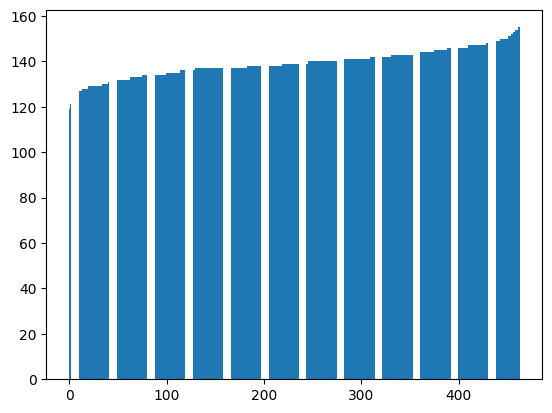

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

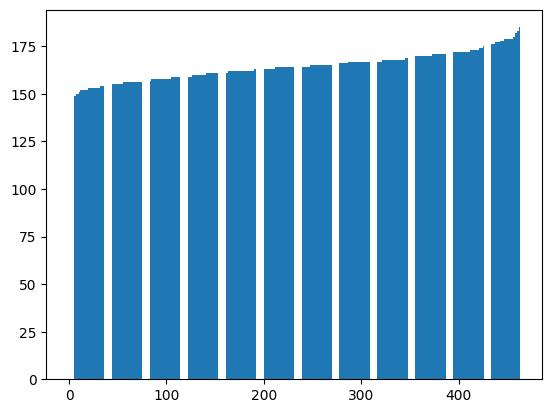

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

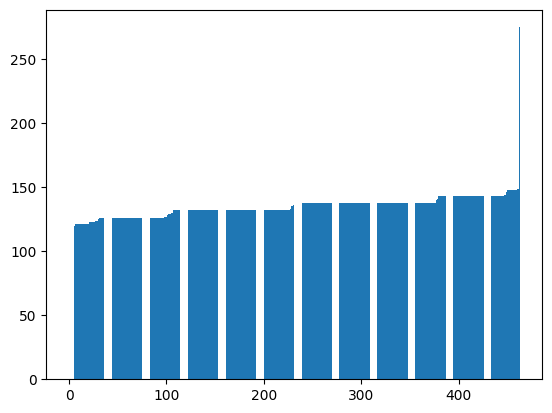

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [23]:
# get average image shape over all the patients

x_values = []
y_values = []
z_values = []

for shape in image_shape_array:
    x_values.append(shape[0])
    y_values.append(shape[1])
    z_values.append(shape[2])

shape_arrays = {"x_values" : x_values,
                "y_values" : y_values,
                "z_values" : z_values}

for key, value_list in shape_arrays.items():
    print(f"average {key}: {np.average(value_list)}")
    print(f"std {key}: {np.std(value_list)}")
    print(f"max {key}: {np.max(value_list)}")
    print(f"min {key}: {np.min(value_list)}")
    print()

x_values.sort()
y_values.sort()
z_values.sort()

x_dict = {}
y_dict = {}
z_dict = {}

for n in range(len(x_values)):
    x_dict[n] = x_values[n]

for n in range(len(y_values)):
    y_dict[n] = y_values[n]

for n in range(len(z_values)):
    z_dict[n] = z_values[n]

plt.bar(x_dict.keys(), x_dict.values())
plt.show()

print(x_dict.keys())
print()
print(x_dict.values())

plt.bar(y_dict.keys(), y_dict.values())
plt.show()

print(y_dict.keys())
print()
print(y_dict.values())

plt.bar(z_dict.keys(), z_dict.values())
plt.show()

print(z_dict.keys())
print()
print(z_dict.values())

Conclusion: 2 patient images are oddly shaped

consider removing the patient with the large z score

In [38]:
# get patient with the large z score

max_z = 0
largest_shape = ()

for value in image_shape_dict.values():
    if value[2] > max_z:
        max_z = value[2]
        largest_shape = value

print(largest_shape)

print(list(image_shape_dict.keys())[list(image_shape_dict.values()).index(largest_shape)])

print(image_shape_dict["sub-01383503"])

(139, 172, 275)
sub-01383503
(139, 172, 275)


consider dropping sub-01383503 for the training set as the z-value of its shape is quite large (275 compared to the average 134)

Image shape for further preprocessing:
(155, 185, 149)

sub-01695080
82


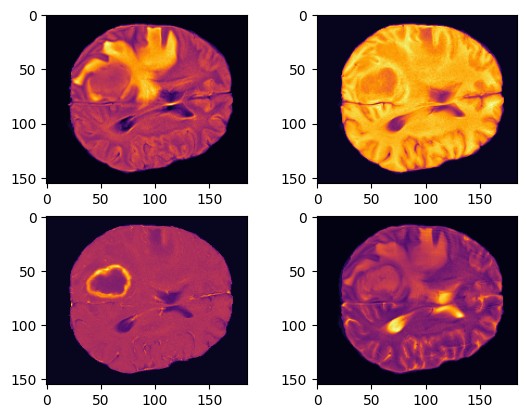

In [123]:
import numpy as np
import nibabel as nib
from skimage import transform
import os
import matplotlib.pyplot as plt

def pad_nifti_images_min_value(file_paths, target_shape):
    padded_images = []

    for file_path in file_paths:
        # Load NIfTI file using nibabel
        img = nib.load(file_path)
        data = img.get_fdata()

        current_shape = data.shape

        # Find the minimum value in the original image
        min_value = data[:,:,0][0][0]

        # Calculate the padding amounts for each dimension
        pad_widths = []
        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))

        # Pad the image using numpy.pad with the minimum value
        padded_data = np.pad(data, pad_widths, mode='constant', constant_values=min_value)

        # Create a new NIfTI image with the padded data
        #padded_img = nib.Nifti1Image(padded_data, img.affine)

        # Save the padded NIfTI image if needed
        #padded_file_path = os.path.join('padded_min_value', os.path.basename(file_path))
        #nib.save(padded_img, padded_file_path)

        padded_images.append(padded_data)

    return padded_images

patient_nmbr = np.random.randint(0, 460)
print(patient_folders[patient_nmbr])

images = os.listdir(os.path.join(path_to_images_folder, patient_folders[patient_nmbr]))
images = [ path_to_images_folder + "/" + patient_folders[patient_nmbr] + "/" + image for image in images]

padded_images = pad_nifti_images_min_value(images, target_shape=(155, 185, 149))

slice = np.random.randint(0, 149)
print(slice)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(padded_images[0][:,:,slice], cmap="inferno")
# axs[0, 0].title = images[0]
axs[0, 1].imshow(padded_images[1][:,:,slice], cmap="inferno")
# axs[0, 1].title = images[1]
axs[1, 0].imshow(padded_images[2][:,:,slice], cmap="inferno")
# axs[1, 0].title = images[2]
axs[1, 1].imshow(padded_images[3][:,:,slice], cmap="inferno")
# axs[1, 1].title = images[3]

In [ ]:
import nibabel as nib
import numpy as np

def load_and_merge_sequences(file_paths):
    sequences = []
    
    for file_path in file_paths:
        # Load NIfTI file
        img = nib.load(file_path)
        
        # Get the image data
        img_data = img.get_fdata()
        
        # Normalize the intensity values (optional but often useful)
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        # Add the sequence to the list
        sequences.append(img_data)

    # Convert the list of sequences into a numpy array with the fourth axis
    merged_array = np.stack(sequences, axis=-1)

    return merged_array

# Example usage:
# Replace the file_paths list with the paths to your NIfTI files for each sequence
file_paths = ['path_to_T1w.nii', 'path_to_T2w.nii', 'path_to_T2-FLAIR.nii', 'path_to_T1ce.nii']

merged_data = load_and_merge_sequences(file_paths)

# Now, merged_data is a numpy array with shape (x, y, z, 4), where the fourth axis represents the different MRI sequences

## Create AI architecture

## Train AI